In [668]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, auc, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
%matplotlib inline

In [711]:
#data = pd.read_csv('../ult_sign_scrape/race_master/master_database.csv')
fe4 = pd.read_csv('../ult_sign_scrape/race_master/master_database_fe4.csv')
athletes = pd.read_csv('../ult_sign_scrape/athlete_dataframe/concat')
races = pd.read_csv('../ult_sign_scrape/race_master/master_list.csv')

In [712]:
#clean = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
fe4_clean = fe4.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
fe4 = fe4_clean.dropna()

In [713]:
fe4.corr()

,age,participant_id,runner_rank,status,race_id,Season,Metro_area,WL_SO,Age_Rank,Gender_Rank,Total_races
age,1.000000,-0.270411,-0.216783,0.075115,-0.010206,0.047769,0.018868,-0.042234,-0.007417,0.000602,0.011360
participant_id,-0.270411,1.000000,-0.194335,-0.001664,0.386143,-0.020922,0.029178,-0.089267,-0.005315,-0.005174,-0.015240
runner_rank,-0.216783,-0.194335,1.000000,-0.190380,0.020117,-0.074137,-0.018915,0.112452,-0.003333,-0.008166,0.007546
status,0.075115,-0.001664,-0.190380,1.000000,0.032448,0.079697,-0.038195,-0.150450,0.007557,0.009809,-0.000989
race_id,-0.010206,0.386143,0.020117,0.032448,1.000000,-0.058049,0.130348,-0.140636,-0.015521,-0.024019,-0.029799
Season,0.047769,-0.020922,-0.074137,0.079697,-0.058049,1.000000,-0.229057,-0.488075,-0.004094,-0.006021,0.019240
Metro_area,0.018868,0.029178,-0.018915,-0.038195,0.130348,-0.229057,1.000000,-0.306849,-0.010899,-0.017804,-0.007776
WL_SO,-0.042234,-0.089267,0.112452,-0.150450,-0.140636,-0.488075,-0.306849,1.000000,0.027897,0.026131,0.011520
Age_Rank,-0.007417,-0.005315,-0.003333,0.007557,-0.015521,-0.004094,-0.010899,0.027897,1.000000,0.766592,0.177129
Gender_Rank,0.000602,-0.005174,-0.008166,0.009809,-0.024019,-0.006021,-0.017804,0.026131,0.766592,1.000000,0.157633


Interesting observation - Very little spread between 25-75% in age of entrants (35-49). Max is 79 and min is ~12 (some cleaning of 0/1 ages may be necessary). 39-44 is the most common ages with nearly 400 in each category. Mid-life crisis???


Interesting observation - Appears that runner rank and age have the strongest relationships to the status column. Gender rank and age rank are similar in their relationship. Total races appears to have the weakest relationship for these features.

In [714]:
gender_dummies_fe = pd.get_dummies(fe4.gender, prefix='gender')
#state_dummies = pd.get_dummies(fe2_clean.state, prefix='Home_State')
fe4 = fe4.join(gender_dummies_fe)
#fe4_clean = fe4_clean.join(state_dummies)

In [715]:
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded
 

print 'Before Coding:'
print pd.value_counts(fe4["status"])
fe4["status_coded"] = coding(fe4["status"], {'1':0,'2':0, '3':1})
print '\nAfter Coding:'
print pd.value_counts(fe4["status_coded"])
fe4 = fe4.drop(['status'], axis=1)
fe4.head()

Before Coding:
1    6291
2    3930
3     540
Name: status, dtype: int64

After Coding:
0    10221
1      540
Name: status_coded, dtype: int64


,age,gender,participant_id,runner_rank,race_id,race_name,Season,Metro_area,WL_SO,Age_Rank,Gender_Rank,Total_races,gender_F,gender_M,status_coded
0,26,M,7148,88.39,11470,Bear,3,0,1,0.7174,0.6806,23.0,0.0,1.0,0
1,33,M,221721,90.00,11470,Bear,3,0,1,0.8132,0.6987,9.0,0.0,1.0,0
2,43,M,20020,83.63,11470,Bear,3,0,1,0.8272,0.7145,17.0,0.0,1.0,0
3,36,M,25441,73.22,11470,Bear,3,0,1,0.8995,0.8957,18.0,0.0,1.0,0
4,33,M,22562,87.77,11470,Bear,3,0,1,0.6807,0.6522,8.0,0.0,1.0,0


In [716]:
fe4.describe()

,age,participant_id,runner_rank,race_id,Season,Metro_area,WL_SO,Age_Rank,Gender_Rank,Total_races,gender_F,gender_M,status_coded
count,10761.000000,1.076100e+04,10761.000000,10761.000000,10761.000000,10761.000000,10761.000000,10761.000000,10761.000000,10761.000000,10761.000000,10761.000000,10761.000000
mean,42.779481,2.714212e+05,69.950043,24829.516866,2.469008,0.705139,0.636558,0.730872,0.667381,11.729951,0.251835,0.748165,0.050181
std,9.865196,2.933872e+05,12.997761,8206.243441,0.736585,0.456001,0.481013,0.204156,0.170511,19.889423,0.434087,0.434087,0.218329
min,0.000000,4.890000e+02,0.000000,11470.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,35.000000,2.183900e+04,63.060000,17746.000000,2.000000,0.000000,0.000000,0.674800,0.602100,1.000000,0.000000,0.000000,0.000000
50%,42.000000,1.686890e+05,69.890000,24962.000000,3.000000,1.000000,1.000000,0.762400,0.679400,2.000000,0.000000,1.000000,0.000000
75%,50.000000,4.350870e+05,77.470000,33769.000000,3.000000,1.000000,1.000000,0.849200,0.763800,15.000000,1.000000,1.000000,0.000000
max,79.000000,1.180368e+06,100.000000,35969.000000,4.000000,1.000000,1.000000,1.000000,1.000000,247.000000,1.000000,1.000000,1.000000


Once adding gender dummies, it appears that gender in and of itself may not be a great predictor of race status. Appears to be ~75% male and 25% female particitation in these races.

In [717]:
y = fe4.pop('status_coded')
clean = fe4.drop(['gender', 'participant_id', 'race_name', 'race_id', 'Age_Rank', 'Gender_Rank', 'Total_races'], axis=1)
X = clean

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

In [719]:
X_train

,age,runner_rank,Season,Metro_area,WL_SO,gender_F,gender_M
6813,41,85.23,4,1,0,1.0,0.0
9042,30,88.92,1,1,1,0.0,1.0
663,55,74.19,3,0,1,1.0,0.0
8822,49,73.58,2,1,1,1.0,0.0
2141,26,70.61,2,0,1,0.0,1.0
7656,51,62.76,2,1,1,0.0,1.0
3742,35,64.51,3,1,0,1.0,0.0
6739,48,58.96,2,1,1,1.0,0.0
1247,24,85.52,4,1,0,0.0,1.0
2143,52,56.98,2,0,1,0.0,1.0


In [720]:
model = LR()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [721]:
predicted = model.predict_proba(X_test)

In [722]:
log_loss(y_test, predicted)

0.19158459921967103

In [723]:
model.coef_

array([[ -5.49432081e-03,  -6.35661033e-04,  -1.64751578e-01,
         -9.06675676e-01,  -9.22660826e-01,  -4.51577784e-01,
         -3.17041564e-01]])

In [725]:
model2 = RFC(n_estimators=5000, criterion='entropy', random_state=1, n_jobs=2)
model2.fit(X_train, y_train)
predicted2 = model2.predict_proba(X_test)
log_loss(y_test, predicted2)

0.33019931874703312

In [727]:
model3 = GBC()
model3.fit(X_train, y_train)
predictions = model3.predict_proba(X_test)
log_loss(y_test, predictions)

0.18681267212318881

In [708]:
len(X_train), len(y_train), len(X_test), len(y_test)

(7532, 7532, 3229, 3229)

In [724]:
#Logistic Regression
roc_auc_score(y_test, predicted[:,1])

0.60275639459107211

In [726]:
#Random Forest
roc_auc_score(y_test, predicted2[:,1])

0.71763705604431416

In [728]:
#GBC
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
auc(fpr, tpr)

0.68519061583577712

In [685]:
neighbor = knn(n_neighbors=1000, p=2, metric='minkowski')
neighbor.fit(X_train, y_train)
knn_predict = neighbor.predict_proba(X_test)
log_loss(y_test, knn_predict)

0.19955071357135232

In [479]:
clf1 = LR(C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = knn(n_neighbors=1, p=2)
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print '10-fold cross validation:'
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print 'ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label)

10-fold cross validation:
ROC AUC: 0.52 (+/- 0.05) [Logistic Regression]
ROC AUC: 0.52 (+/- 0.03) [Decision Tree]
ROC AUC: 0.51 (+/- 0.02) [KNN]


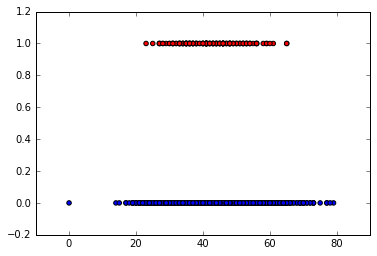

In [515]:
lst = ['r', 'b']
new = ['r' if each == 1 else 'b' for each in y_test]
plt.scatter(X_test['age'], y_test, c=new)

In [517]:
df = clean[y == 1]